In [ ]:
import sys

print(sys.executable)

/home/matt/Dev/ma-communicative-robots-G1/combots-venv-new/bin/python


# SETUP

In [ ]:
# Matt
import os
import sys

# sys.path.append(os.path.abspath('../combots-venv-new/lib/python3.12/site-packages'))
%pip install cltl.combot --break-system-packages
%pip install python-dotenv
from dotenv import load_dotenv

# Get the current working directory
current_dir = os.getcwd()
# Construct the relative path to the .env file
env_path = os.path.join(current_dir, "../.env")
# Load the .env file
load_dotenv(env_path)


# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Colab
%pip install --upgrade ai2thor --quiet
%pip install ai2thor-colab prior --upgrade &> /dev/null
%pip install python-dotenv
%pip install cltl.combot --break-system-packages
import os

os.system("apt-get install xvfb")
import ai2thor_colab

ai2thor_colab.start_xserver()

from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of marshmallow-dataclass to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00
  Created wheel for emissor: filename=emissor-0.0.dev6-py3-none-any.whl size=28072 sh

  if event.key is 'enter':



In [2]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 1709.03it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [3]:
house = dataset["train"][11]  # CHOOSE HOUSE

In [4]:
from ai2thor.controller import Controller
from PIL import Image

In [5]:
controller = Controller(scene=house, visibilityDistance=10, width=750, height=750)

thor-Linux64-f0825767cd50d69f666c7f282e54abfe58f1e917.zip: [ 100%  32.0 MiB/s]  of 769.MB


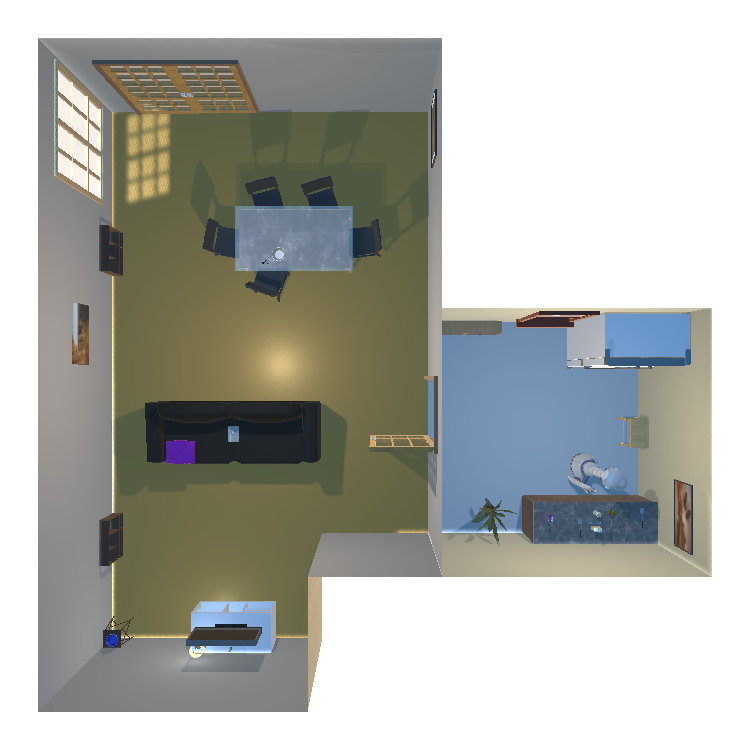

In [32]:
import copy

def get_top_down_frame():
    # Setup the top-down camera
    event = controller.step(action="GetMapViewCameraProperties", raise_for_failure=True)
    pose = copy.deepcopy(event.metadata["actionReturn"])

    bounds = event.metadata["sceneBounds"]["size"]
    max_bound = max(bounds["x"], bounds["z"])

    pose["fieldOfView"] = 50
    pose["position"]["y"] += 1.1 * max_bound
    pose["orthographic"] = False
    pose["farClippingPlane"] = 50
    del pose["orthographicSize"]

    # add the camera to the scene
    event = controller.step(
        action="AddThirdPartyCamera",
        **pose,
        skyboxColor="white",
        raise_for_failure=True,
    )
    top_down_frame = event.third_party_camera_frames[-1]
    return Image.fromarray(top_down_frame)


get_top_down_frame()

In [6]:
event = controller.step(action="GetReachablePositions")
reachable_positions = event.metadata["actionReturn"]

In [7]:
from openaiapi import analyze_image, analyze_prompt
from utils import numpy_to_base64

frame = controller.last_event.frame
base64_string = numpy_to_base64(frame)

# FUNCTIONS

In [8]:
#init array for all the positions agent visited in case of worst case scenario
visited_positions = []

In [9]:
import math


def teleport_in_front_of_object(
    controller, object_position, reachable_positions, distance=1.0
):
    """Teleports the agent to the closest reachable position in front of an object.

    Args:
      controller: The AI2Thor controller.
      object_position: The position of the target object.
      reachable_positions: A list of reachable positions in the scene.
      distance: The desired distance in front of the object.

    Returns:
      The event after teleporting.
    """

    # Calculate the target position in front of the object
    target_position = {
        "x": object_position["x"] - distance,
        "y": object_position["y"],
        "z": object_position["z"],
    }

    # Find the closest reachable position
    closest_position = None
    min_distance = float("inf")

    for position in reachable_positions:
        dist = math.sqrt(
            (position["x"] - target_position["x"]) ** 2
            + (position["z"] - target_position["z"]) ** 2
        )
        if dist < min_distance:
            min_distance = dist
            closest_position = position

    # Calculate rotation towards the object
    dx = object_position["x"] - closest_position["x"]
    dz = object_position["z"] - closest_position["z"]
    rotation = math.degrees(math.atan2(dx, dz))

    # Teleport and rotate
    event = controller.step(
        action="Teleport", position=closest_position, rotation=rotation
    )
    agent_position = controller.last_event.metadata['agent']['position']
    visited_positions.append(agent_position)

    return event  # Return the event after adjusting view angle

In [10]:
def get_object_positions(controller, matched_object):
    """
    Finds the positions of all visible objects of a specific type.

    Args:
      controller: The AI2Thor controller.
      matched_object: The type of object to find (e.g., "Painting", "Chair", "Table").

    Returns:
      A list of positions for the specified object type.
    """
    visible_objects = [
        obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
    ]
    objects_of_interest = [
        obj for obj in visible_objects if obj["objectType"] == matched_object
    ]
    object_positions = []
    for obj in objects_of_interest:
        # print(obj["name"], obj["position"])
        object_positions.append(obj["position"])
    return object_positions

In [11]:
import re


def interactive_object_match(
    api_key: str,
    human_object_description: str,
    unique_object_list: list,
    HUMAN: str,
    AGENT: str,
    leolaniClient,
):
    """
    Interactively matches a human description of an object to one from a given list using an LLM.
    The function continues to refine guesses based on user confirmation or denial.

    Args:
        api_key (str): The API key for accessing the LLM.
        human_object_description (str): A description of the object to match.
        unique_object_list (list): The list of unique objects to match against.

    Returns:
        str: The confirmed object from the user.
        list: The matched object(s) from the list based on the LLM's response.
    """

    def ask_llm(description: str, objects: list) -> str:
        """Helper function to query the LLM for matching the description."""
        object_list_str = ", ".join(objects)
        prompt = (
            f"Imagine you are tasked with identifying an object from a given list based on its description. "
            f"The list of objects is: {object_list_str}. "
            f"Your task is to match the following description to one or more objects from the list: \n"
            f"'{description}'\n\n"
            "If you have a single best guess, respond with: 'To be sure, would you describe your object as {object}? '\n"
            "If you are unsure and need clarification between a few options, respond with: "
            "'To be sure, would you describe your object as {object1} or {object2}? '"
            "Only use objects from the list."
        )
        # Make sure the response is extracted correctly from the LLM
        llm_response = analyze_prompt(api_key=api_key, prompt=prompt)

        if isinstance(llm_response, tuple):
            llm_response = llm_response[0]

        if (
            isinstance(llm_response, list) and llm_response
        ):  # Check if it's a non-empty list
            llm_response = llm_response[0]  # Access the first element if it's a list

        if (
            isinstance(llm_response, dict)
            and "choices" in llm_response
            and llm_response["choices"]
        ):
            return llm_response["choices"][0]["message"]["content"]
        return llm_response  # Return raw response if format is unexpected

    current_description = human_object_description

    while True:
        # Query the LLM for a guess
        response = ask_llm(current_description, unique_object_list)
        leolaniClient._add_utterance(AGENT, response)
        print(f"{AGENT}>{response}")

        # Extract the matched object(s) from the response
        matched_objects = re.findall(
            r"\b(" + "|".join(map(re.escape, unique_object_list)) + r")\b", response
        )

        if matched_objects:
            # Ask the user for confirmation or denial
            confirmation_prompt = f"Is this correct? (yes/no): "
            leolaniClient._add_utterance(AGENT, confirmation_prompt)
            print(f"{AGENT}>{confirmation_prompt}")
            user_input = input().strip().lower()
            leolaniClient._add_utterance(HUMAN, user_input)
            print(f"{HUMAN}>{user_input}")

            if user_input == "yes":
                success_message = "Great! Object successfully matched."
                leolaniClient._add_utterance(AGENT, success_message)
                print(f"{AGENT}>{success_message}")
                return (
                    matched_objects[0] if len(matched_objects) == 1 else matched_objects
                )
            elif user_input == "no":
                refine_message = "Let's refine the search. Can you provide more details or clarify the description?"
                leolaniClient._add_utterance(AGENT, refine_message)
                print(f"{AGENT}>{refine_message}")
                clarifying_question = input().strip()
                leolaniClient._add_utterance(HUMAN, clarifying_question)
                print(f"{HUMAN}>{clarifying_question}")
                current_description = (
                    clarifying_question  # Update the description with the new input
                )
            else:
                error_message = "Please respond with 'yes' or 'no'."
                leolaniClient._add_utterance(AGENT, error_message)
                print(f"{AGENT}>{error_message}")
        else:
            error_message = (
                "I couldn't find a matching object. Can you provide more details?"
            )
            leolaniClient._add_utterance(AGENT, error_message)
            print(f"{AGENT}>{error_message}")
            clarifying_question = input().strip()
            leolaniClient._add_utterance(HUMAN, clarifying_question)
            print(f"{HUMAN}>{clarifying_question}")
            current_description += " " + clarifying_question

In [12]:
unique_object_list = [
    "AlarmClock",
    "AluminumFoil",
    "Apple",
    "ArmChair",
    "BaseballBat",
    "BasketBall",
    "Bathtub",
    "BathtubBasin",
    "Bed",
    "Blinds",
    "Book",
    "Boots",
    "Bottle",
    "Bowl",
    "Box",
    "Bread",
    "ButterKnife",
    "Cabinet",
    "Candle",
    "CD",
    "CellPhone",
    "Chair",
    "Cloth",
    "CoffeeMachine",
    "CoffeeTable",
    "CounterTop",
    "CreditCard",
    "Cup",
    "Curtains",
    "Desk",
    "DeskLamp",
    "Desktop",
    "DiningTable",
    "DishSponge",
    "DogBed",
    "Drawer",
    "Dresser",
    "Dumbbell",
    "Egg",
    "Faucet",
    "Floor",
    "FloorLamp",
    "Footstool",
    "Fork",
    "Fridge",
    "GarbageBag",
    "GarbageCan",
    "HandTowel",
    "HandTowelHolder",
    "HousePlant",
    "Kettle",
    "KeyChain",
    "Knife",
    "Ladle",
    "Laptop",
    "LaundryHamper",
    "Lettuce",
    "LightSwitch",
    "Microwave",
    "Mirror",
    "Mug",
    "Newspaper",
    "Ottoman",
    "Painting",
    "Pan",
    "PaperTowelRoll",
    "Pen",
    "Pencil",
    "PepperShaker",
    "Pillow",
    "Plate",
    "Plunger",
    "Poster",
    "Pot",
    "Potato",
    "RemoteControl",
    "RoomDecor",
    "Safe",
    "SaltShaker",
    "ScrubBrush",
    "Shelf",
    "ShelvingUnit",
    "ShowerCurtain",
    "ShowerDoor",
    "ShowerGlass",
    "ShowerHead",
    "SideTable",
    "Sink",
    "SinkBasin",
    "SoapBar",
    "SoapBottle",
    "Sofa",
    "Spatula",
    "Spoon",
    "SprayBottle",
    "Statue",
    "Stool",
    "StoveBurner",
    "StoveKnob",
    "TableTopDecor",
    "TargetCircle",
    "TeddyBear",
    "Television",
    "TennisRacket",
    "TissueBox",
    "Toaster",
    "Toilet",
    "ToiletPaper",
    "ToiletPaperHanger",
    "Tomato",
    "Towel",
    "TowelHolder",
    "TVStand",
    "VacuumCleaner",
    "Vase",
    "Watch",
    "WateringCan",
    "Window",
    "WineBottle",
]

# Test Interaction

In [13]:
# adding to the system path
import sys

sys.path.insert(0, os.path.abspath("../emissor_chat"))

from leolani_client import Action, LeolaniChatClient

emissor_path = "./emissor"
AGENT = "Ai2Thor"
HUMAN = "Human"
leolaniClient = LeolaniChatClient(emissor_path=emissor_path, agent=AGENT, human=HUMAN)

In [14]:
utterance = f"Hi {HUMAN}. What do you see in the room?"
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Hi Human. What do you see in the room?


In [15]:
# grab img of an item to look for

# example: look for a tv in a room
# event = controller.step(action="Teleport", position={'x': 2.75, 'y': 0.9009997844696045, 'z': 1.0}  with rotation 209)
# Image.fromarray(event.frame)

In [16]:
human_room_description = (
    "there is a table. 5 chairs. wthere is a window. its probably a living room."
)

In [17]:
print(HUMAN + ">" + human_room_description)
leolaniClient._add_utterance(HUMAN, human_room_description)

Human>there is a table. 5 chairs. wthere is a window. its probably a living room.


In [18]:
# claryfying questions
claryfying_questions_response = analyze_prompt(
    api_key=api_key,
    model="gpt-4o-mini",
    prompt=f"Imagine you are a robot who needs to be on a exact location as the point of view that the human has. After a while, the human can no longer see this image. The human will most likely describe a room from memory. The human will most likely describe a few objects and maybe some other attributes, like colours of objects. Your task is to ask claryfing questions about the room and objects so that you (the robot) has the highest chance of finding where the human was standing. Remember, ask the questions as if you were directly talking to the human. Try not to ask for too much details and dont ask for too much; remember, the human has to describe the image from memory, so only ask what you deem most important. \n Human description: {human_room_description}",
)

In [19]:
claryfying_questions_response

({'id': 'chatcmpl-AagsUkFSyEdJcUeNh8AvIJ4z4X5NR',
  'object': 'chat.completion',
  'created': 1733307994,
  'model': 'gpt-4o-mini-2024-07-18',
  'choices': [{'index': 0,
    'message': {'role': 'assistant',
     'content': 'Thank you for the description! To help me understand the location better, can you tell me more about the table? What shape is it, and what color is it? Also, do you remember if there were any particular objects on the table?',
     'refusal': None},
    'logprobs': None,
    'finish_reason': 'stop'}],
  'usage': {'prompt_tokens': 184,
   'completion_tokens': 49,
   'total_tokens': 233,
   'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0},
   'completion_tokens_details': {'reasoning_tokens': 0,
    'audio_tokens': 0,
    'accepted_prediction_tokens': 0,
    'rejected_prediction_tokens': 0}},
  'system_fingerprint': 'fp_3de1288069'},
 1.6109418869018555)

In [20]:
utterance = claryfying_questions_response[0]["choices"][0]["message"]["content"]
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Thank you for the description! To help me understand the location better, can you tell me more about the table? What shape is it, and what color is it? Also, do you remember if there were any particular objects on the table?


In [21]:
human_room_description_clarified = "The table is blue, chairs are all black. The window is on the left wall in the same corner as th balcony doors."
print(HUMAN + ">" + human_room_description_clarified)
leolaniClient._add_utterance(HUMAN, human_room_description)

Human>The table is blue, chairs are all black. The window is on the left wall in the same corner as th balcony doors.


In [22]:
utterance = "Describe the object I should look for."
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Describe the object I should look for.


In [23]:
human_obj_description = "It's a dark painting with trees a moon. some clouds, a river."

In [24]:
print(HUMAN + ">" + human_obj_description)
leolaniClient._add_utterance(HUMAN, human_room_description)

Human>It's a dark painting with trees a moon. some clouds, a river.


In [25]:
# this is where the interactive object match comes :
# based on "dark painting with trees ...", did you mean "Painting"?

human_object_description = human_obj_description
matched_object = interactive_object_match(
    api_key=api_key,
    human_object_description=human_object_description,
    unique_object_list=unique_object_list,
    HUMAN=HUMAN,
    AGENT=AGENT,
    leolaniClient=leolaniClient,
)

Ai2Thor>To be sure, would you describe your object as Painting?
Ai2Thor>Is this correct? (yes/no): 
yes
Human>yes
Ai2Thor>Great! Object successfully matched.


In [26]:
matched_object

'Painting'

In [27]:
# Teleport somewhere random
import random

position = random.choice(reachable_positions)
rotation = random.choice(range(360))
print("Teleporting the agent to", position, " with rotation", rotation)

event = controller.step(action="Teleport", position=position, rotation=rotation)
agent_position = controller.last_event.metadata['agent']['position']
visited_positions.append(agent_position)

# Image.fromarray(event.frame) # image for clearity

Teleporting the agent to {'x': 1.25, 'y': 0.9009997844696045, 'z': 6.0}  with rotation 300


In [28]:
# location classificaiton:

# chatgpt, do you think you are in the correct room based on human_room_description + human_room description_clarified? (maybe rotate 360 degrees, but also have to analyze 4 images then)

room_classifcation = analyze_image(
    base64_string,
    api_key=api_key,
    prompt=f"Imagine you are a robot looking for a certain room. Describe the room shortly. Do you think you are in the correct room based on the following description? Description: {human_room_description}, even further description: {human_room_description_clarified}, speak to me as if you have the robots point of view. Be consise in your answer.",
)
utterance = room_classifcation[0]["choices"][0]["message"]["content"]
print(AGENT + ">" + utterance)
leolaniClient._add_utterance(AGENT, utterance)

Ai2Thor>Scanning room.

Features detected:
- Blue table.
- Five black chairs.
- Window on left wall.
- Adjacent balcony doors.

Conclusion: This matches the room description. Correct room located.


In [29]:
# TO DO: Decide what to do: teleport to another room, teleport to object instance (if there is one) or lookleft/lookright etc
def find_all_object_positions(controller, object_type, num_rotations=3):
    """
    Finds the positions of all objects of a specific type by rotating the agent.

    Args:
      controller: The AI2Thor controller.
      object_type: The type of object to find (e.g., "Painting", "Chair", "Table").
      num_rotations: The number of times to rotate the agent to scan for objects.

    Returns:
      A list of positions for the specified object type.
    """
    all_object_positions = []  # To store all object positions

    for _ in range(num_rotations):  # Rotate specified number of times
        # Get visible objects and their positions
        visible_objects = [
            obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
        ]
        objects_of_interest = [
            obj for obj in visible_objects if obj["objectType"] == object_type
        ]
        current_object_positions = []
        for obj in objects_of_interest:
            print(obj["name"], obj["position"])  # Optional: Print object details
            current_object_positions.append(obj["position"])

        # Add current object positions to the overall list
        all_object_positions.extend(current_object_positions)

        # Rotate the agent
        controller.step("RotateRight")

    return all_object_positions


In [30]:
# Metadata

# i see x instances of matched_object
# teleport to matched_object[0]
# use chatgpt to describe image
# do so until image is found or no instances left

# matched_object = "Painting" # placeholder

#object_positions = get_object_positions(controller, matched_object)
object_positions = find_all_object_positions(controller, matched_object)

for i in range(len(object_positions)):
    position = object_positions[i]
    event = teleport_in_front_of_object(controller, position, reachable_positions)

    description = analyze_image(
        base64_string,
        api_key=api_key,
        prompt=f"describe {matched_object} in great detail",
    )
    utterance = description[0]["choices"][0]["message"]["content"]

    print(AGENT + ">" + utterance + "Was this the item you were looking for?")
    leolaniClient._add_utterance(
        AGENT, utterance + "Was this the item you were looking for?"
    )
    if input("Type yes if so...") == "yes":
        print(HUMAN + ">" + "yes")
        leolaniClient._add_utterance(HUMAN, "yes")
        break
    else:
        print(HUMAN + ">" + "no")
        leolaniClient._add_utterance(HUMAN, "no")
        continue

print("Teleport to new room if item isn't found")

Painting|3|6 {'x': 5.0281662940979, 'y': 1.585843563079834, 'z': 7.616852760314941}
Painting|2|6 {'x': 8.383004188537598, 'y': 1.8958626985549927, 'z': 2.2807140350341797}
Ai2Thor>The painting on the wall is a landscape featuring urban architecture. It depicts a row of buildings, characterized by a grid of windows, under a bright sky. The artwork uses a realistic style, capturing the essence of an urban environment. The composition is well-balanced, with the buildings occupying the middle ground and providing a sense of depth and perspective. The colors are muted, with shades of gray, blue, and beige dominating the palette, suggesting a calm and serene atmosphere.Was this the item you were looking for?
Type yes if so...no
Human>no
Ai2Thor>The painting hanging on the wall is a rectangular piece with a dark frame. It depicts a dramatic landscape with a sweeping vista of hills or possibly mountains under a dynamic sky. The sky shows a gradient of colors, suggesting either sunrise or sunse

In [ ]:
print(visited_positions)

[{'x': 6.25, 'y': 0.9009993672370911, 'z': 3.5}, {'x': 7.5, 'y': 0.9009993672370911, 'z': 2.75}, {'x': 0.5, 'y': 0.9009993672370911, 'z': 5.0}]


In [ ]:
print(reachable_positions)

[{'x': 2.5, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 2.75, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 2.5, 'y': 0.9009997844696045, 'z': 5.0}, {'x': 2.25, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 2.5, 'y': 0.9009997844696045, 'z': 4.5}, {'x': 3.0, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 2.75, 'y': 0.9009997844696045, 'z': 5.0}, {'x': 2.75, 'y': 0.9009997844696045, 'z': 4.5}, {'x': 2.25, 'y': 0.9009997844696045, 'z': 5.0}, {'x': 2.0, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 2.25, 'y': 0.9009997844696045, 'z': 4.5}, {'x': 2.5, 'y': 0.9009997844696045, 'z': 4.25}, {'x': 3.25, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 3.0, 'y': 0.9009997844696045, 'z': 5.0}, {'x': 3.0, 'y': 0.9009997844696045, 'z': 4.5}, {'x': 2.75, 'y': 0.9009997844696045, 'z': 4.25}, {'x': 2.25, 'y': 0.9009997844696045, 'z': 5.25}, {'x': 2.0, 'y': 0.9009997844696045, 'z': 5.0}, {'x': 1.75, 'y': 0.9009997844696045, 'z': 4.75}, {'x': 2.0, 'y': 0.9009997844696045, 'z': 4.5}, {'x': 2.25, 'y': 0.9009997844696045, 'z

In [ ]:
def euclidean_distance_2d(pos1, pos2):
    """
    Calculate the Euclidean distance between two positions in 2D space (x and z axes).

    Args:
        pos1 (dict): The first position with 'x' and 'z' coordinates.
        pos2 (dict): The second position with 'x' and 'z' coordinates.

    Returns:
        float: The Euclidean distance between the two positions.
    """
    return math.sqrt((pos1['x'] - pos2['x'])**2 + (pos1['z'] - pos2['z'])**2)

In [ ]:
def get_farthest_position(reachable_positions, visited_positions):
    """
    Find the reachable position that is farthest from any of the visited positions.

    Args:
        reachable_positions (list): A list of reachable positions (each position is a dict with 'x', 'y', 'z').
        visited_positions (list): A list of positions already visited.

    Returns:
        dict: The position in reachable_positions that is farthest from visited_positions.
    """
    max_min_distance = -1
    farthest_position = None
    for position in reachable_positions:
        # Compute distances to all visited positions
        distances = [euclidean_distance_2d(position, visited_pos) for visited_pos in visited_positions]
        # Find the minimum distance to the visited positions
        min_distance = min(distances)
        # Update if this is the farthest minimum distance found so far
        if min_distance > max_min_distance:
            max_min_distance = min_distance
            farthest_position = position
    return farthest_position

In [ ]:
farthest_position = get_farthest_position(reachable_positions, visited_positions)
print(farthest_position)

{'x': 4.5, 'y': 0.9009997844696045, 'z': 8.0}


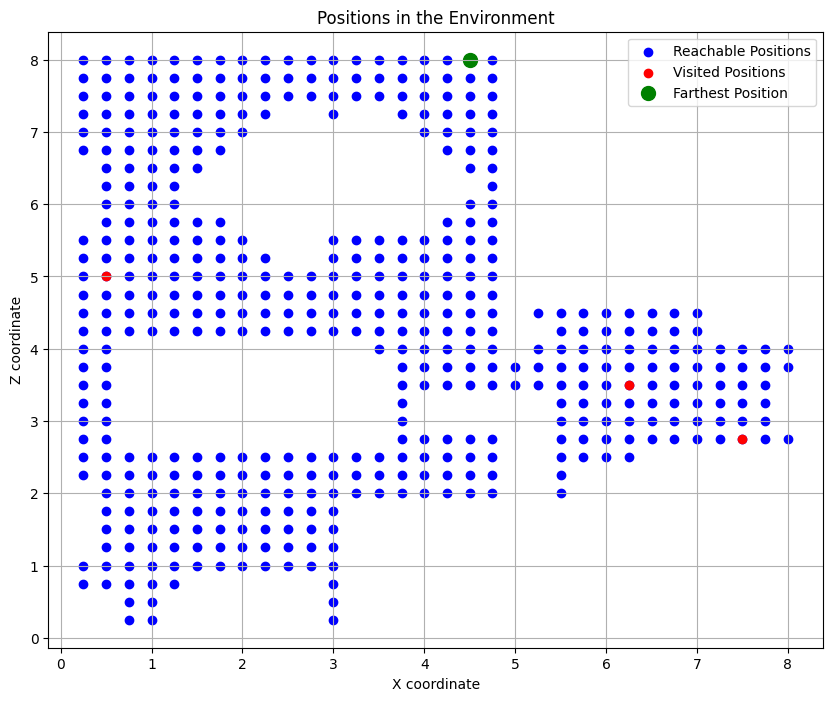

In [ ]:
import matplotlib.pyplot as plt

# Extract x and z coordinates
visited_x = [pos['x'] for pos in visited_positions]
visited_z = [pos['z'] for pos in visited_positions]
reachable_x = [pos['x'] for pos in reachable_positions]
reachable_z = [pos['z'] for pos in reachable_positions]

# Plot the positions
plt.figure(figsize=(10, 8))
plt.scatter(reachable_x, reachable_z, c='blue', label='Reachable Positions')
plt.scatter(visited_x, visited_z, c='red', label='Visited Positions')
plt.scatter(farthest_position['x'], farthest_position['z'], c='green', label='Farthest Position', s=100)
plt.xlabel('X coordinate')
plt.ylabel('Z coordinate')
plt.title('Positions in the Environment')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TO DO: if no more instances, teleport to new room

# Look at the furthest away coordinate compared to the visited coordinates, just take the eucliadian distances of each point.

In [ ]:
##### After completion, we save the scenario in the defined emissor folder.
leolaniClient._save_scenario()

# EXAMPLE IMAGES

RANDOM TELEPORT

In [ ]:
import random

position = random.choice(reachable_positions)
rotation = random.choice(range(360))
print("Teleporting the agent to", position, " with rotation", rotation)

event = controller.step(action="Teleport", position=position, rotation=rotation)
Image.fromarray(event.frame)

IMAGE WITH 2 PAINTING

In [ ]:
event = controller.step(
    action="Teleport",
    position={"x": 2.5, "y": 0.9009997844696045, "z": 4.5},
    rotation=80,
)
Image.fromarray(event.frame)

#TESTING

ROTATING AND REMEMBERING OBJECT LOCATIONS

In [ ]:
visible_objects = [
    obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
]
paintings = [obj for obj in visible_objects if obj["objectType"] == "Painting"]
all_painting_positions = []  # To store all painting positions

for _ in range(3):  # Rotate three times
    # Get visible paintings and their positions
    current_painting_positions = []
    for painting in paintings:
        print(painting["name"], painting["position"])
        current_painting_positions.append(painting["position"])

    # Add current painting positions to the overall list
    all_painting_positions.extend(current_painting_positions)

    # Rotate the agent
    controller.step("RotateRight")

    # Update visible objects and paintings for the next iteration
    visible_objects = [
        obj for obj in controller.last_event.metadata["objects"] if obj["visible"]
    ]
    paintings = [obj for obj in visible_objects if obj["objectType"] == "Painting"]

print("All painting positions in the room:", all_painting_positions)

LOOK UP / DOWN

In [ ]:
# controller.step("LookDown")
# Image.fromarray(controller.last_event.frame)

# after we take look up or down we should return to the original state, THIS IS IMPORTANT OTHERWISE IT WILL MESS WITH TELEPORTING